***
**Tutorial for Chapter 2**

Case study 1: College Attending Plan Modeled by Decision Tree
***
<font color = 'darkred'>*Reference:*
<font color = 'darkred'>*Python数据挖掘实战*

<!-- Acknowledgement:  
**i2DM (Tan, Steinbach, Kumar (2018) Introduction to Data Mining , 2nd Ed, Pearson )** Pearson Press   -->
For the course AMA546 Statistical Data Mining   
Lecturer: Dr. Catherine Liu    
AMA, PolyU, HKSAR

In [1]:
import pandas
import numpy as np
from sklearn.preprocessing import OneHotEncoder # Import one-hot encoder
from scipy.sparse import hstack # Import hstack to stack the data
from sklearn.tree import DecisionTreeClassifier # Import the decision tree classifier
from sklearn.tree import plot_tree # Impor the tree plot module to plot the decision tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt # Import plot module

# Objectives of the analysis

This case study looks at college attending plan. In this case, the government's education department would like to know how many students want to go to college, but high school students may not be willing to share such private information with the education department. So the government needs to predict whether high school students are willing to go to college, and then give instructions to public universities and labor departments. Whether high school students go to college is mainly influenced by themselves and their parents. One way to perform this analysis is to use student data available to the education department. The data in this case study came from a city government that wanted us to be able to use this desensitized student data to make predictions about whether high school students were willing to go to college. 

The purpose of this study is to use the basic information of high school students to predict whether they plan to go to college, in particular, which factors can better distinguish high school students who are willing to go to college from those who are not. That could help colleges plan their admissions ahead of time and help the government predict the number of high-school students who will need jobs during graduation season. In data mining terms, we are concerned with classification problems. Therefore, classification algorithms, especially the decision tree algorithm you learned about, can be used for analysis.

# Description of the data 

Here we will give a brief introduction to the dataset. The data sent to us by the government is in `csv` format, containing numbers and strings. Students' names are desensitized and replaced by StudentID to prevent information leakage. According to the government official who spoke with us, the data was taken from the actual enrollment data of the city last year, and the last column `Plan` indicates whether the high school student finally made plans to go to college. The explanatory variables we were able to use included the gender of the student, the IQ of the student, the income of the parents and whether the parents encouraged the child to go to college. Government officials tell us that in their long-term observation, these four factors are the most important factors in whether high school students plan to go to college. The data given to us by government officials is extensive, but analyzing the entire data set is expensive and time-consuming, so we have taken a partial sample for you to analyze. You can get up to 8,000 samples, which is enough to help you train a stable decision tree. The table below details the explanatory variables you can use:

<table>
<thead>
  <tr>
    <th>Variable</th>
    <th>Explanation</th>
    <th>Range</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>StudentID</td>
    <td>The unique identify number of the student</td>
    <td>1, 2, ..., 8000</td>
  </tr>
  <tr>
    <td>Gender</td>
    <td>The gender of the student</td>
    <td>{male, female}</td>
  </tr>
  <tr>
    <td>Parent_income</td>
    <td>The annual income of the parents, in US dollars</td>
    <td>[4500, 82390]</td>
  </tr>
  <tr>
    <td>IQ</td>
    <td>The IQ of the student in the last test</td>
    <td>[60, 140]</td>
  </tr>
  <tr>
    <td>Encourage</td>
    <td>Whether the parents encourage their child to go to the college</td>
    <td>{encourage, not encourage}</td>
  </tr>
  <tr>
    <td>Plan</td>
    <td>Whether the student eventually plans to go to college</td>
    <td>{plan, not plan}<br></td>
  </tr>
</tbody>
</table>

In [2]:
data_college = pandas.read_csv('college.csv',engine='python') # Parser engine to use. The C is faster while the python is currently more feature-complete.
data_college.head()

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
0,4558,male,53900,118,encourage,plan
1,4561,female,24900,87,not encourage,not plan
2,4563,female,65800,93,not encourage,not plan
3,4565,male,11440,117,encourage,plan
4,4567,female,16700,102,not encourage,not plan


#  Exploratory data analysis 

## Data quality (No need in our case)

Before starting the actual data analysis, we first need to determine the quality of the dataset. Any missing values or outliers in our dataset could cause bugs in our code or biases in our model. Fortunately, the government helped us clean up our data beforehand. There is no **NA** or **Null** data in the dataset.

In [3]:
# There is no NA or Null data in the dataframe
print(data_college[data_college.isnull().any(axis=1)])
print(data_college[data_college.isna().any(axis=1)])

Empty DataFrame
Columns: [StudentID, Gender, Parent_income, IQ, Encourage, Plan]
Index: []
Empty DataFrame
Columns: [StudentID, Gender, Parent_income, IQ, Encourage, Plan]
Index: []


In addition, we want to know whether there are **outliers** in the observations, that is, whether there are observations of some samples that are unexpected. If so, it may be due to errors in data collection by the staff, or the data does have characteristics that are different from other data and require additional analysis. We first output some statistics on the numerical variable in our dataset, as you can see, the StudentID is quite neat. The median annual income of parents is \\$40,584, the lowest is \\$4,500, and the highest is \\$82,390, both within the reasonable range. Students' IQ ranges from 60 to 140, which is also within the reasonable range.

In [4]:
data_college.describe()

,StudentID,Parent_income,IQ
count,8000.00000,8000.000000,8000.000000
mean,4000.50000,40584.017500,99.577750
std,2309.54541,18031.506468,18.923655
min,1.00000,4500.000000,60.000000
25%,2000.75000,29400.000000,90.000000
50%,4000.50000,39330.000000,100.000000
75%,6000.25000,51592.500000,110.000000
max,8000.00000,82390.000000,140.000000


As for string variables, as noted in the description of the data, they take only legal values. All in all, our data set is pretty clean.

In [5]:
# Aggregate the data
def rstr(df): return df.apply(lambda x: [x.unique()]) # define a function
rstr(data_college[['Encourage', 'Plan']])

,Encourage,Plan
0,"[encourage, not encourage]","[plan, not plan]"


*One may also consider data quality problems like data format, replicated data and so on.* 

## Marginal variable analysis

Below, we will study the conditional distribution of the response variable on the explanatory variables. The data will be presented in percentage form for easy comparison. We can draw following conclusions:
 - ***Gender***: First, the data set is balanced between men and women, with slightly fewer men (48.4%) and more women (51.6%). Secondly, in general, 67.6% of high school students do not want to go to college to study. The proportion of male high school students with the intention to study is more, accounting for 36.4% of the male high school students. There are 28.7% of female high school students want to go to college. 
<table><thead><tr><th>Gender</th><th>Total</th></tr></thead><tbody><tr><td>Male</td><td>51.6%</td></tr><tr><td>Female</td><td>48.4%</td></tr></tbody></table>

In [6]:
# Gender
crosstb = pandas.crosstab(index = data_college['Gender'],
                      columns = data_college['Plan'],
                      normalize='index', margins = True,
                      margins_name= "Total") *100
round(crosstb,1).astype(str).apply(lambda x:x + '%')

Plan,not plan,plan
Gender,,
female,71.3%,28.7%
male,63.6%,36.4%
Total,67.6%,32.4%


- ***Encourage***: Overall, 51.7% of parents encourage their children to go to college, while 48.3% do not. Among the high school students encouraged by their parents to go to college, 57.0% of them plan to go to college, which is not very differentiated. But notice that 93.8% of the kids whose parents don't encourage them to go to college have no plans to do so, which is a huge difference. This reminds us that `Encourage` may be a good variable for predicting the college attending plan.

<table><thead><tr><th>Encourage</th><th>Total</th></tr></thead><tbody><tr><td>encourage</td><td>51.7%</td></tr><tr><td>not encourage<br></td><td>48.3%</td></tr></tbody></table>

In [7]:
# Encourage plan
crosstb = pandas.crosstab(index = data_college['Encourage'],
                      columns = data_college['Plan'],
                      normalize='index', margins = True,
                      margins_name= "Total") *100
round(crosstb,1).astype(str).apply(lambda x:x + '%')

Plan,not plan,plan
Encourage,,
encourage,43.0%,57.0%
not encourage,93.8%,6.2%
Total,67.6%,32.4%


 - ***Parent income & IQ***: 
For parents' income and students' IQ, we used boxplots to compare the degree to which they rated whether high school students planned to go to college or not. If the two resulting boxplots differ markedly in position (e.g. in terms of the median) for students who plan to go to school and those who don't, the corresponding variable can be deemed relevant. As can be observed from the chart below, in terms of parental income, students who plan to attend college are significantly higher than those who plan not to attend college. Of course, you can see some outliers above the upper whisker of students who plan on not going to college, suggesting that there are a small number of students whose parents have higher incomes who also don't plan on going to college. In terms of student IQ, students who plan to attend college are higher than those who plan not to attend college, but there is some overlap.

**Supplement material**
A [boxplot](https://en.wikipedia.org/wiki/Box_plot) is a standardized way of displaying the dataset based on the five-number summary: the minimum, the maximum, the sample median, and the first and third quartiles.

     - Minimum (Q0 or 0th percentile): the lowest data point in the data set excluding any outliers
     - Maximum (Q4 or 100th percentile): the highest data point in the data set excluding any outliers
     - Median (Q2 or 50th percentile): the middle value in the data set
     - First quartile (Q1 or 25th percentile): also known as the lower quartile qn(0.25), it is the median of the lower half of the dataset.
     - Third quartile (Q3 or 75th percentile): also known as the upper quartile qn(0.75), it is the median of the upper half of the dataset.
In addition to the minimum and maximum values used to construct a box-plot, another important element that can also be employed to obtain a box-plot is the interquartile range (IQR), as denoted below:

     - Interquartile range (IQR) : the distance between the upper and lower quartiles:
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/55207ed597c8171bd024775fabf80dc36b1be30e' width=300>
 <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Elements_of_a_boxplot_en.svg/600px-Elements_of_a_boxplot_en.svg.png' width=500>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


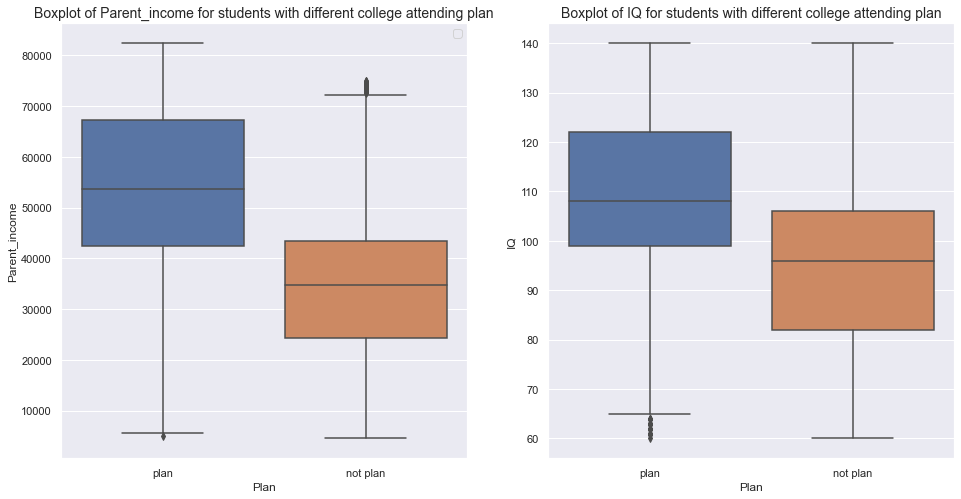

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Creation of figure with 2 axis
sns.set(style="ticks")
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Creation of 1st axis
sns.boxplot(x="Plan", y="Parent_income", data=data_college, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title("Boxplot of Parent_income for students with different college attending plan", fontsize=14)
# Creation of 2nd axis
sns.boxplot(x="Plan", y="IQ", data=data_college, ax=ax[1])
ax[1].set_title("Boxplot of IQ for students with different college attending plan", fontsize=14)
# Close the empty Figure 2 created by seaborn.
plt.close(2)

## Data preprocessing

Before building the model, we need to preprocess the data. Because the "Sex" and "Encourage" columns are strings, the classifier does not recognize them. We're going to use some coding scheme to convert them. We're not going to convert the variable types, they're still qualitative nominal variables, but they're going to be converted into a form that the classifier recognizes.

The [one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) will help you do this job. The input to this encoder should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are encoded using a one-hot (also known as ‘one-of-K’ or ‘dummy’) encoding scheme. This creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse of the output parameter).

<img src='https://datagy.io/wp-content/uploads/2022/01/One-Hot-Encoding-for-Scikit-Learn-in-Python-Explained-1024x576.png' width = 600>

<!-- For [example](https://www.cnblogs.com/zhoukui/p/9159909.html), for input:
```
Gender	Encourage
male	  encourage
male	  not encourage
female	not encourage
female    encourage
```
the one-hot encode will be:
```
1	  2	
1.0	0.0
1.0    1.0
0.0	1.0
0.0	0.0
```
where male is coded as 1, female is encoded as 0, not encourage is coded as 1, encourage is coded as 0. -->


Below, we encode the 'Gender' and 'Encourage' columns into one-hot form:

In [9]:
# Build an one-hot encoder
oneHotEncoder = OneHotEncoder()
# Train the one-hot encoder to get the transformation of columns that need to be processed by one-hot encoder
oneHotEncoder.fit(data_college[['Gender', 'Encourage']])
# Transform the data
oneHotData = oneHotEncoder.transform(data_college[['Gender', 'Encourage']])

Let's look at the result of one-hot coding: the output is a matrix with two columns of features replaced by four columns. Compare this to the original 'Gender' and 'Encourage' column, and you will find the rule of the one-hot encoder.

 - In the first two columns:
     - male is coded as (0, 1) ,
     - female is encoded as (1, 0).
 - In the last two columns:
     - not encourage is coded as (0, 1),
     - encourage is coded as (1, 0)
     
<table><thead><tr><th></th><th>Gender</th><th>Encourage</th></tr></thead><tbody><tr><td>0</td><td>male</td><td>encourage</td></tr><tr><td>1</td><td>female</td><td>not encourage</td></tr><tr><td>2</td><td>female</td><td>not encourage</td></tr><tr><td>3</td><td>male</td><td>encourage</td></tr><tr><td>4</td><td>female</td><td>not encourage</td></tr></tbody></table>

In [10]:
pandas.DataFrame(oneHotData[:5].toarray())
# print(oneHotData[:5]) #index-value form

,0,1,2,3
0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0


After transforming the two columns into one-hot encoding, we need to merge the one-hot columns with the `Parent_income` and `IQ` columns by column.

In [11]:
# Combine the data obtained from the one-hot code with the parental income and IQ
x = hstack([
    oneHotData, 
    data_college.Parent_income.values.reshape(-1, 1), 
    data_college.IQ.values.reshape(-1, 1)
])
# pandas.DataFrame(x.toarray()[:5])
# The response variable
y = data_college["Plan"]

# Model building 

**Recall: decision tree**
The decision tree algorithm falls under the category of supervised learning, which means the response variable exists and can be observed. They can be used to solve both regression and classification problems. Decision tree uses the tree representation to solve the problem in which each leaf node corresponds to a class label and attributes are represented on the internal node of the tree. We can represent any boolean function on discrete attributes using the decision tree.

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20221212133528/dcsion.png' width=800>

As you can see from the above image, we are predicting whether a person like playing computer game. In the Decision Tree, the major challenge is the identification of the attribute for the root node at each level. This process is known as attribute selection.

For each node, we use **impurity** to measure the purity of each node. Let $p(i|t)$ denote the fraction of objects in node $t$, that belong to class $i$. And $c$ is the total number of the classes. We have the following *measures of impurity*: (for each node t)
\begin{align*}
\textrm{Entropy}(t) &= -\sum_{i = 1}^{c} p(i \mid t) \log_{2} p(i\mid t)\\
\textrm{Gini}(t) &= 1-\sum_{i = 1}^{c} p(i \mid t)^{2}\\
\textrm{ ClassificationError }(t) &=1-\max_{i}p(i \mid t)
\end{align*}

A popular attribute selection measure is the **information gain**:

\begin{align*}
\Delta=I(\text { parent })-\sum_{j=1}^{k} \frac{N\left(v_{j}\right)}{N} I\left(v_{j}\right)
\end{align*}

where $I(·)$ is the impurity measure of a given node (like, Gini, Entropy or ClassificationError), and $k$ is the total number of attribute values (for example if the attribute is binary, then $k$ = 2), and $v_1$, . . . , $v_k$ are the child nodes. $N$ is the number of records at the parent node, and $N(v_j)$ is the number of records at node $v_j$.

Here is an example on computing the information gain:

<table><thead><tr><th></th><th></th><th>node1</th><th>node2</th><th>Total</th></tr></thead><tbody><tr><td rowspan="2">Attribute R</td><td>1</td><td>9</td><td>1</td><td>10</td></tr><tr><td>0</td><td>4</td><td>6</td><td>10</td></tr><tr><td></td><td>Total</td><td>13</td><td>7</td><td>20</td></tr><tr><td></td><td>Gini</td><td>0.4260</td><td>.2449</td><td>0.5000</td></tr></tbody></table>

then the information gain is:

\begin{align*}
    \Delta &= .5-\frac{13}{20}.4260-\frac{7}{20}.2449\\
           &= .1374,
\end{align*}

The information gain is the amount of information that can be brought by using the attribute R for classification. We look for the attribute that maximizes the information gain, so that the classified nodes are as clean as possible, that is, the classes are separated as much as possible. Moreover, we find that all $I(Parent)$ are the same, so finding the maximum information gain can be translated into finding the minimum $\sum_{j=1}^{k} \frac{N\left(v_{j}\right)}{N} I\left(v_{j}\right)$.

**In this tutorial, we will use gini to calculate the information gain, and the decision tree generated with this impurity is called CART (Classification And Regression Tree).**

Of course, you can generate a decision tree without any parameter restrictions. In this case, the tree grows until all nodes contain only one class. As you would expect, these decision trees perform very well on the training data. However, these decision trees can be very deep and severely overfit. Overfitting is when a model completely fits the training data and struggles or fails to generalize the testing data. This happens when the model memorizes noise in the training data and fails to pick up essential patterns which can help them with the test data. Decision Trees are one of the machine learning algorithms that are susceptible to **overfitting**. 

In [12]:
### max_depth=None, max_leaf_nodes=None
# Create a decision tree object
dtModel = DecisionTreeClassifier(criterion='gini')
# Train the decision tree by the training data
dtModel.fit(x, y)
# Evaluate the decision tree by the accuracy
dtModel.score(x, y)

0.99725

In [13]:
print('The max deepth of the decision tree:', dtModel.get_depth(),
     '\nThe number of leaves of the decision tree:',dtModel.get_n_leaves())

The max deepth of the decision tree: 30 
The number of leaves of the decision tree: 1668


Look! We are suffering from overfitting: the tree is 30 levels deep, with a total of 1677 nodes.

One of the techniques you can use to reduce overfitting in Decision Trees is **Pruning**. *Pruning is a technique that removes the parts of the Decision Tree which prevent it from growing to its full depth.* The parts that it removes from the tree are the parts that do not provide the power to classify instances. In simpler terms, the aim of Decision Tree Pruning is to construct an algorithm that will perform worse on training data but will generalize better on test data. Tuning the parameters of your Decision Tree model can do your model a lot of justice and save you a lot of time.

We will search optimal parameters by `GridSearchCV`. *GridSearchCV tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the Cross-Validation method.* Hence after using this function we get accuracy/loss for every combination of hyperparameters and we can choose the one with the best performance.

In [14]:
# Create a decision tree object
dtModel = DecisionTreeClassifier()
# Find the optimal parameters by Grid search
paramGrid = dict(
    max_depth=[1, 2, 3, 4, 5],
    max_leaf_nodes=[2, 3, 4, 5, 6, 7, 8],
)
dtModel = DecisionTreeClassifier()

grid = GridSearchCV(
    dtModel, paramGrid, cv=10,
    return_train_score=True
)
grid = grid.fit(x, y)

print('The optimal score is : %f' % grid.best_score_)
print('The optimal parameters are:')
for key in grid.best_params_.keys():
    print('%s=%s'%(key, grid.best_params_[key]))

The optimal score is : 0.836500
The optimal parameters are:
max_depth=4
max_leaf_nodes=7


Using `GridSearchCV`, we find the best model in our search range. The optimal accuarcy is 0.8365 and the optimal parameters are:
 - max_depth=4
 - max_leaf_nodes=7
 
Then, we can train the decision tree model with optimal parameters:

In [15]:
dtModel_opt = DecisionTreeClassifier(
    max_depth=4, 
    max_leaf_nodes=7
)
dtModel_opt.fit(x, y)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=7)

In the following, we plot this decision tree model. 

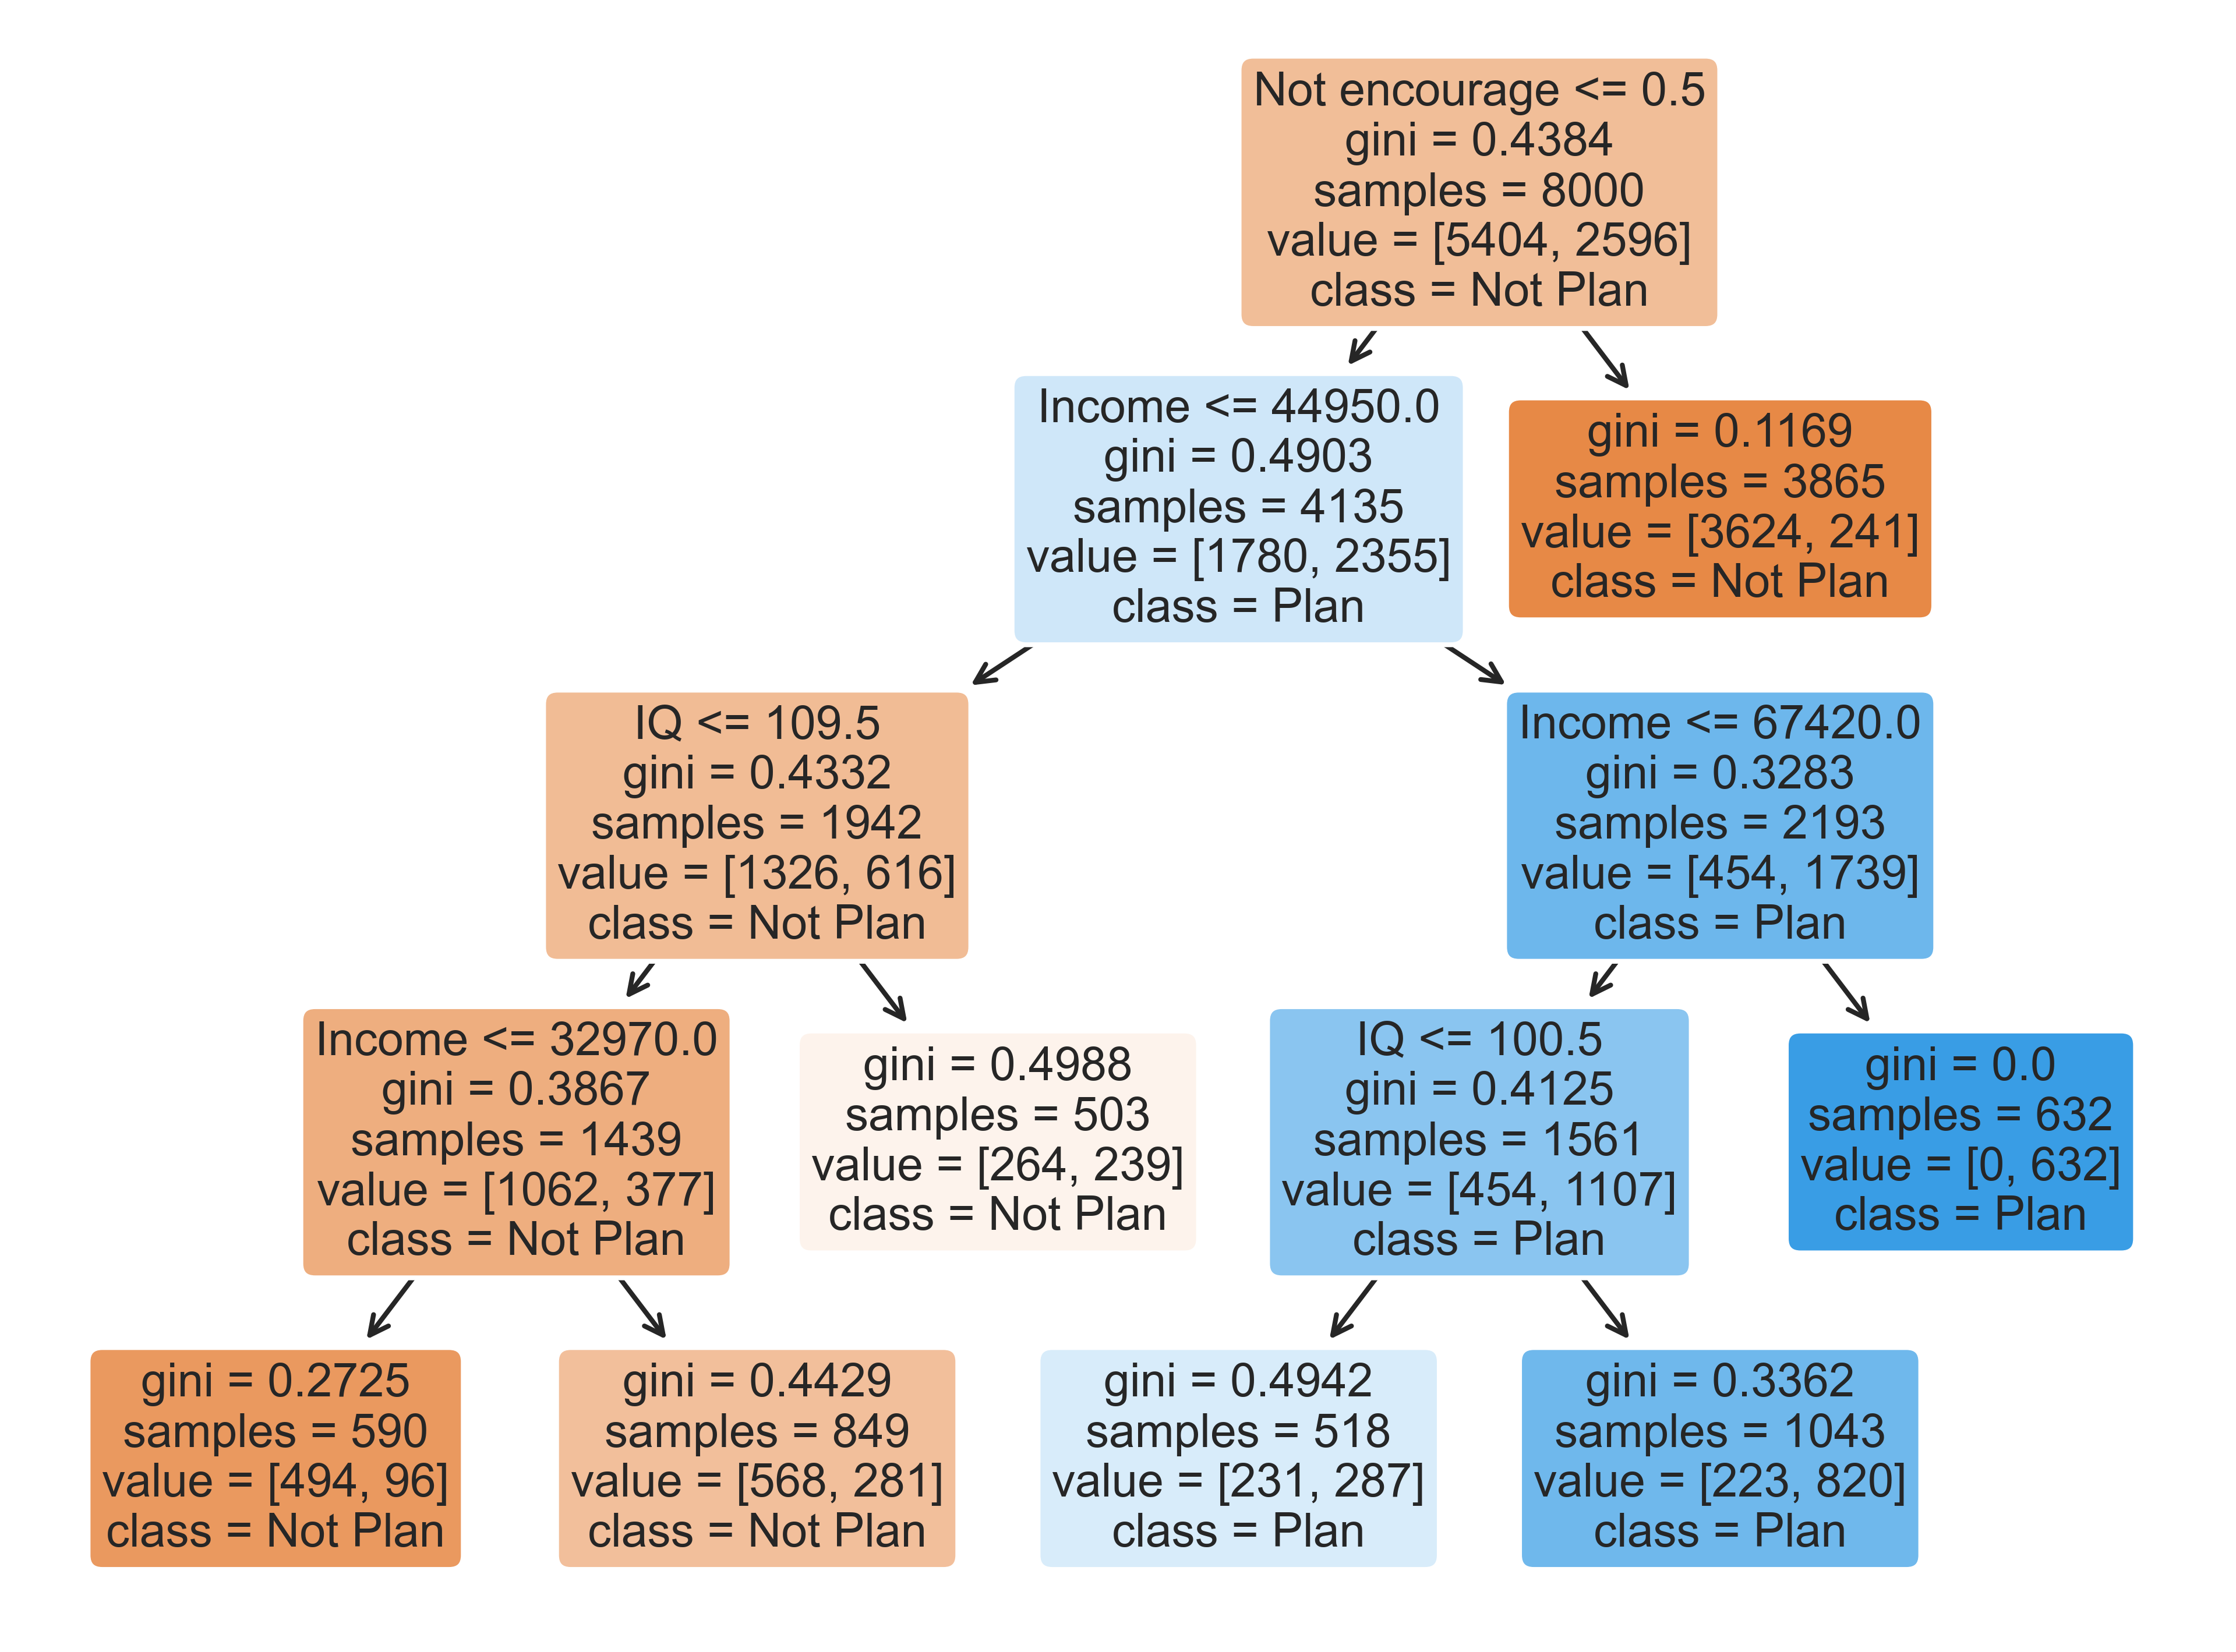

In [16]:
plt.figure(figsize=(8,6), dpi = 600)
plot_tree(dtModel_opt, class_names=['Not Plan', 'Plan'],
          feature_names=['Female', 'Male', 'Encourage', 'Not encourage', 'Income', 'IQ'],
          filled = True , precision = 4, rounded = True)
plt.show()

Let's take a look at the decision tree.

A decision tree is a tree structure similar to a flow chart. When constructing the decision tree, we look for the attribute that maximizes the information gain, so that the classified nodes are as clean as possible. The tree builder will calculate the information gain from each attribute and choose the attribute with the largest information gain. In our cases, the `Encourage` achieves the largest information gain among all the attributes in the first layer.

Starting from the root node, which is the node in the first layer. The first row in the node represents the judgment criteria. **If the judgment criteria meets, the observation falls to the left.** Otherwise, it falls to the right. This process continues **until the observation falls into end leaf**, which is the node that no longer has a judgment criterion. The leaves contains the result of the decision tree.

 - The `samples = 8000` is the total number of the training samples. 
 - The `value = [5404, 2596]` is the number of samples per class. Here, there are 5405 high school students who don't plan to go to college and 2596 who plan to go to college. 
 - Thus, for all samples, this node is biased towards not planning to go to college, which is indicated by `class = Not Plan` in the figure.  
 - Then there is the **Gini index**, which represents the uncertainty of the conclusion, the larger its value is, the greater the uncertainty of the conclusion, and the smaller its value is, the greater the certainty of the conclusion. Here, the root node has a `gini = 0.4384`:
\begin{align*}
\text{gini}_{R}=1-(\frac{5404}{8000})^2-(\frac{2596}{8000})^2=0.4384
\end{align*}
And the node on the left has a `gini = 0.117`, which is smaller than the parent node. This indicates that the certainty becomes larger after classification, and more people are inclined to not plan to go to college. In the node on the right, the gini index is 0.49, which is larger than the parent node. This indicates that the certainty becomes larger after classification and further classification is needed.
 - The **split condition**, which indicates the classification direction of the samples in the root node. The decision trees split like binary trees, and there are only two types of split conditions for a node: True and False. When the condition `Encourage<=0.5` is True, the sample is divided into the left node, and when the parent `Encourage<=0.5` is False, the sample is divided into the right node.

Furthermore, recall what we have already observed in our exploratory data analysis: `Encourage` and `Parent income` have good discrimination effect while `Gender` has poor discrimination. It is reasonable to use only the first two variables in the optimal decision tree and not use `gender` for decision making.

Finally, let us make an interpretation of decision trees. For a high school student, whether the student plans to go to college or not depends first on whether his parents encourage the student or not. High school students who are not encouraged by their parents can hardly have a plan to go to college. 

The second depends on his family income. High school students whose families earn more than \\$44950 a year are more likely to plan to go to college. High school students from families earning less than \\$44950 were less likely to plan to go to college. In particular, when the annual household income is above \\$67420, the probability of the students planning to attend college is very high.

*For continous explanationary variables, [ID3](https://en.wikipedia.org/wiki/ID3_algorithm) decision tree is not capable but [C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm) and [CART](https://www.geeksforgeeks.org/cart-classification-and-regression-tree-in-machine-learning/) decision trees are capable.*

# Summary report

## Context
This case study focuses on predicting college attending plans. In this context, the government wants to understand the willingness of high school students to attend university, but it is difficult to collect such information completely and reliably. So governments need the information they can use to predict whether high school students want to go to college. Government officials believe that factors in high school students themselves and their parents influence whether they attend college. The data in this case study came from a city government, where officials wanted us to be able to use this student data to predict whether high school students were willing to go to college.

## Objectives
The aim of this study is to use the basic information of high school students to predict whether they plan to go to college.

## Organisation of the data
The data set contains a total of 8000 samples. Students use StudentID as a unique identifier. The final column `Plan` indicates whether the high school student ultimately intends to attend college. The explanatory variables include the gender of the student, the IQ of the student, the income of the parents, and whether the parents encouraged their children to attend college.

## Exploratory data analysis：
In the course of the exploratory data analysis, we find that `Encourage` has a strong discriminating effect on whether high school students attend college or not. In addition, we also find through the boxplot that `Parent_income` also have a good discrimination effect. After that, we used one-hot encoder to preprocess the data, so that the dataset could be processed by the decision tree model.

##  Model specification: 
The analysis objective suggested a predictive classification model that allocates high school students to categories with and without plan to go to college. Therefore, we consider decision tree models.

## Model interpretation:
For predicting whether high school students plan to attend college, "Encourage" and "Parent_income" are good discriminators, while "gender" is poor discriminators. According to the optimal decision tree we obtained, for a high school student, the distinction is first made by whether his parents encourage the student to go to college or not. High school students who are not encouraged by their parents have little intention of going to college. Secondly, it is distinguished by his family income. High school students whose families earn more than \\$44950 per year are more likely to plan to attend college.

last modified: sj